# Clasterization 

[Классная ссылка](https://scikit-learn.org/stable/modules/clustering.html#mean-shift)

Представим, что международное круизное агентство Carnival Cruise Line решило себя разрекламировать с помощью баннеров и обратилось для этого к вам. Чтобы протестировать, велика ли от таких баннеров польза, их будет размещено всего 20 штук по всему миру. Вам надо выбрать 20 таких локаций для размещения, чтобы польза была большой и агентство продолжило с вами сотрудничать.

Агентство крупное, и у него есть несколько офисов по всему миру. Вблизи этих офисов оно и хочет разместить баннеры — легче договариваться и проверять результат. Также эти места должны быть популярны среди туристов.

Для поиска оптимальных мест воспользуемся базой данных крупнейшей социальной сети, основанной на локациях — Foursquare.

Часть открытых данных есть, например, на сайте archive.org:


Осталось определить 20 ближайших к ним центров кластеров. Т.е. посчитать дистанцию до ближайшего офиса для каждой точки и выбрать 20 с наименьшим значением.

Примечание: при подсчете расстояний и в кластеризации можно пренебречь тем, что Земля круглая, так как в точках, расположенных близко друг к другу погрешность мала, а в остальных точках значение достаточно велико.


Примечание:на 396634 строках кластеризация будет работать долго. Быть очень терпеливым не возбраняется — результат от этого только улучшится. Но для того, чтобы сдать задание, **понадобится сабсет из первых 100 тысяч строк.** Это компромисс между качеством и затраченным временем. Обучение алгоритма на всём датасете занимает около часа, а на 100 тыс. строк — примерно 2 минуты, однако этого достаточно для получения корректных результатов.

Некоторые из получившихся кластеров содержат слишком мало точек — такие кластеры не интересны рекламодателям. Поэтому надо определить, какие из кластеров содержат, скажем, больше 15 элементов. Центры этих кластеров и являются оптимальными для размещения.

При желании увидеть получившиеся результаты на карте можно передать центры получившихся кластеров в один из инструментов визуализации. Например, сайт mapcustomizer.com имеет функцию Bulk Entry, куда можно вставить центры полученных кластеров в формате:


**Задание**

Для сдачи задания выберите из получившихся 20 центров тот, который наименее удален от ближайшего к нему офиса. Ответ в этом задании — широта (latitude) и долгота этого центра, записанные через пробел.

In [1]:
import pandas as pd
import sklearn
import scipy.sparse 
import numpy as np


import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline 

from sklearn.cluster import MeanShift
import sklearn

pd.options.mode.chained_assignment = None

plt.style.use("bmh")
plt.rcParams['font.family'] = 'DejaVu Sans'

import seaborn as sns
sns.set(style='whitegrid')
plt.rcParams['figure.figsize']=(12,6)
plt.rcParams['figure.dpi']= 300

In [2]:
def date_preprocessing(df, date_col):
    # обрабатываем даты - создаем фичу full_date - всегда 1 число месяца, в котором была коммуникация
    df[date_col] = pd.to_datetime(df[date_col])
    
    # создаем поля дат
    df['month'] = df[date_col].dt.month
    df['year'] = df[date_col].dt.year
    df['day'] = 1
    df['full_date'] = pd.to_datetime(df[['year', 'month', 'day']])
    
    print(f"Observation period: {df[date_col].min(), df[date_col].max()}")
    
    df['full_date'].dt.date.value_counts().sort_index().plot(kind='bar')
    plt.title('Communications per month') 
    plt.show()
    
    df = df[df[date_col] < pd.to_datetime("today")]
    
    return df


## Загрузка данных

In [3]:
data_path = r"D:\study\MIPT_ML\3_Unsupervised_ML\data\checkins.dat"

In [4]:
full_data = pd.read_csv(data_path, sep='|')
full_data.columns = full_data.columns.str.replace(' ','')
full_data.head(3)

d:\programs\anaconda3\envs\sci\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,user_id,venue_id,latitude,longitude,created_at
0,---------+---------+----------+---------------...,NaN,NaN,NaN,NaN,NaN
1,984301,2041916.0,5222.0,,,2012-04-21 17:39:01
2,984222,15824.0,5222.0,38.8951118,-77.0363658,2012-04-21 17:43:47


In [5]:
print("df shape:",full_data.shape)
print("unique id's:", full_data['id'].nunique())
print("unique user_id's:", full_data['user_id'].nunique())

df shape: (1021968, 6)
unique id's: 1021968
unique user_id's: 485381


In [6]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021968 entries, 0 to 1021967
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   id          1021968 non-null  object 
 1   user_id     1021966 non-null  float64
 2   venue_id    1021966 non-null  float64
 3   latitude    1021966 non-null  object 
 4   longitude   1021966 non-null  object 
 5   created_at  1021966 non-null  object 
dtypes: float64(2), object(4)
memory usage: 46.8+ MB


In [7]:
full_data.dropna(subset=['latitude', 'longitude'],axis=0, inplace=True)

# removing white spaces
full_data['latitude'] = full_data['latitude'].str.strip()
full_data['longitude'] = full_data['longitude'].str.strip()

# drop rows without 'latitude' or 'longitude'
full_data = full_data[~((full_data['latitude'] == '') | (full_data['longitude'] == ''))]

In [8]:
# chaning types of data
full_data['created_at'] = pd.to_datetime(full_data['created_at'])
full_data['longitude'] = pd.to_numeric(full_data['longitude'],errors='coerce')
full_data['latitude'] = pd.to_numeric(full_data['latitude'],errors='coerce')

Plot points with coordinates

Text(0, 0.5, 'longitude')

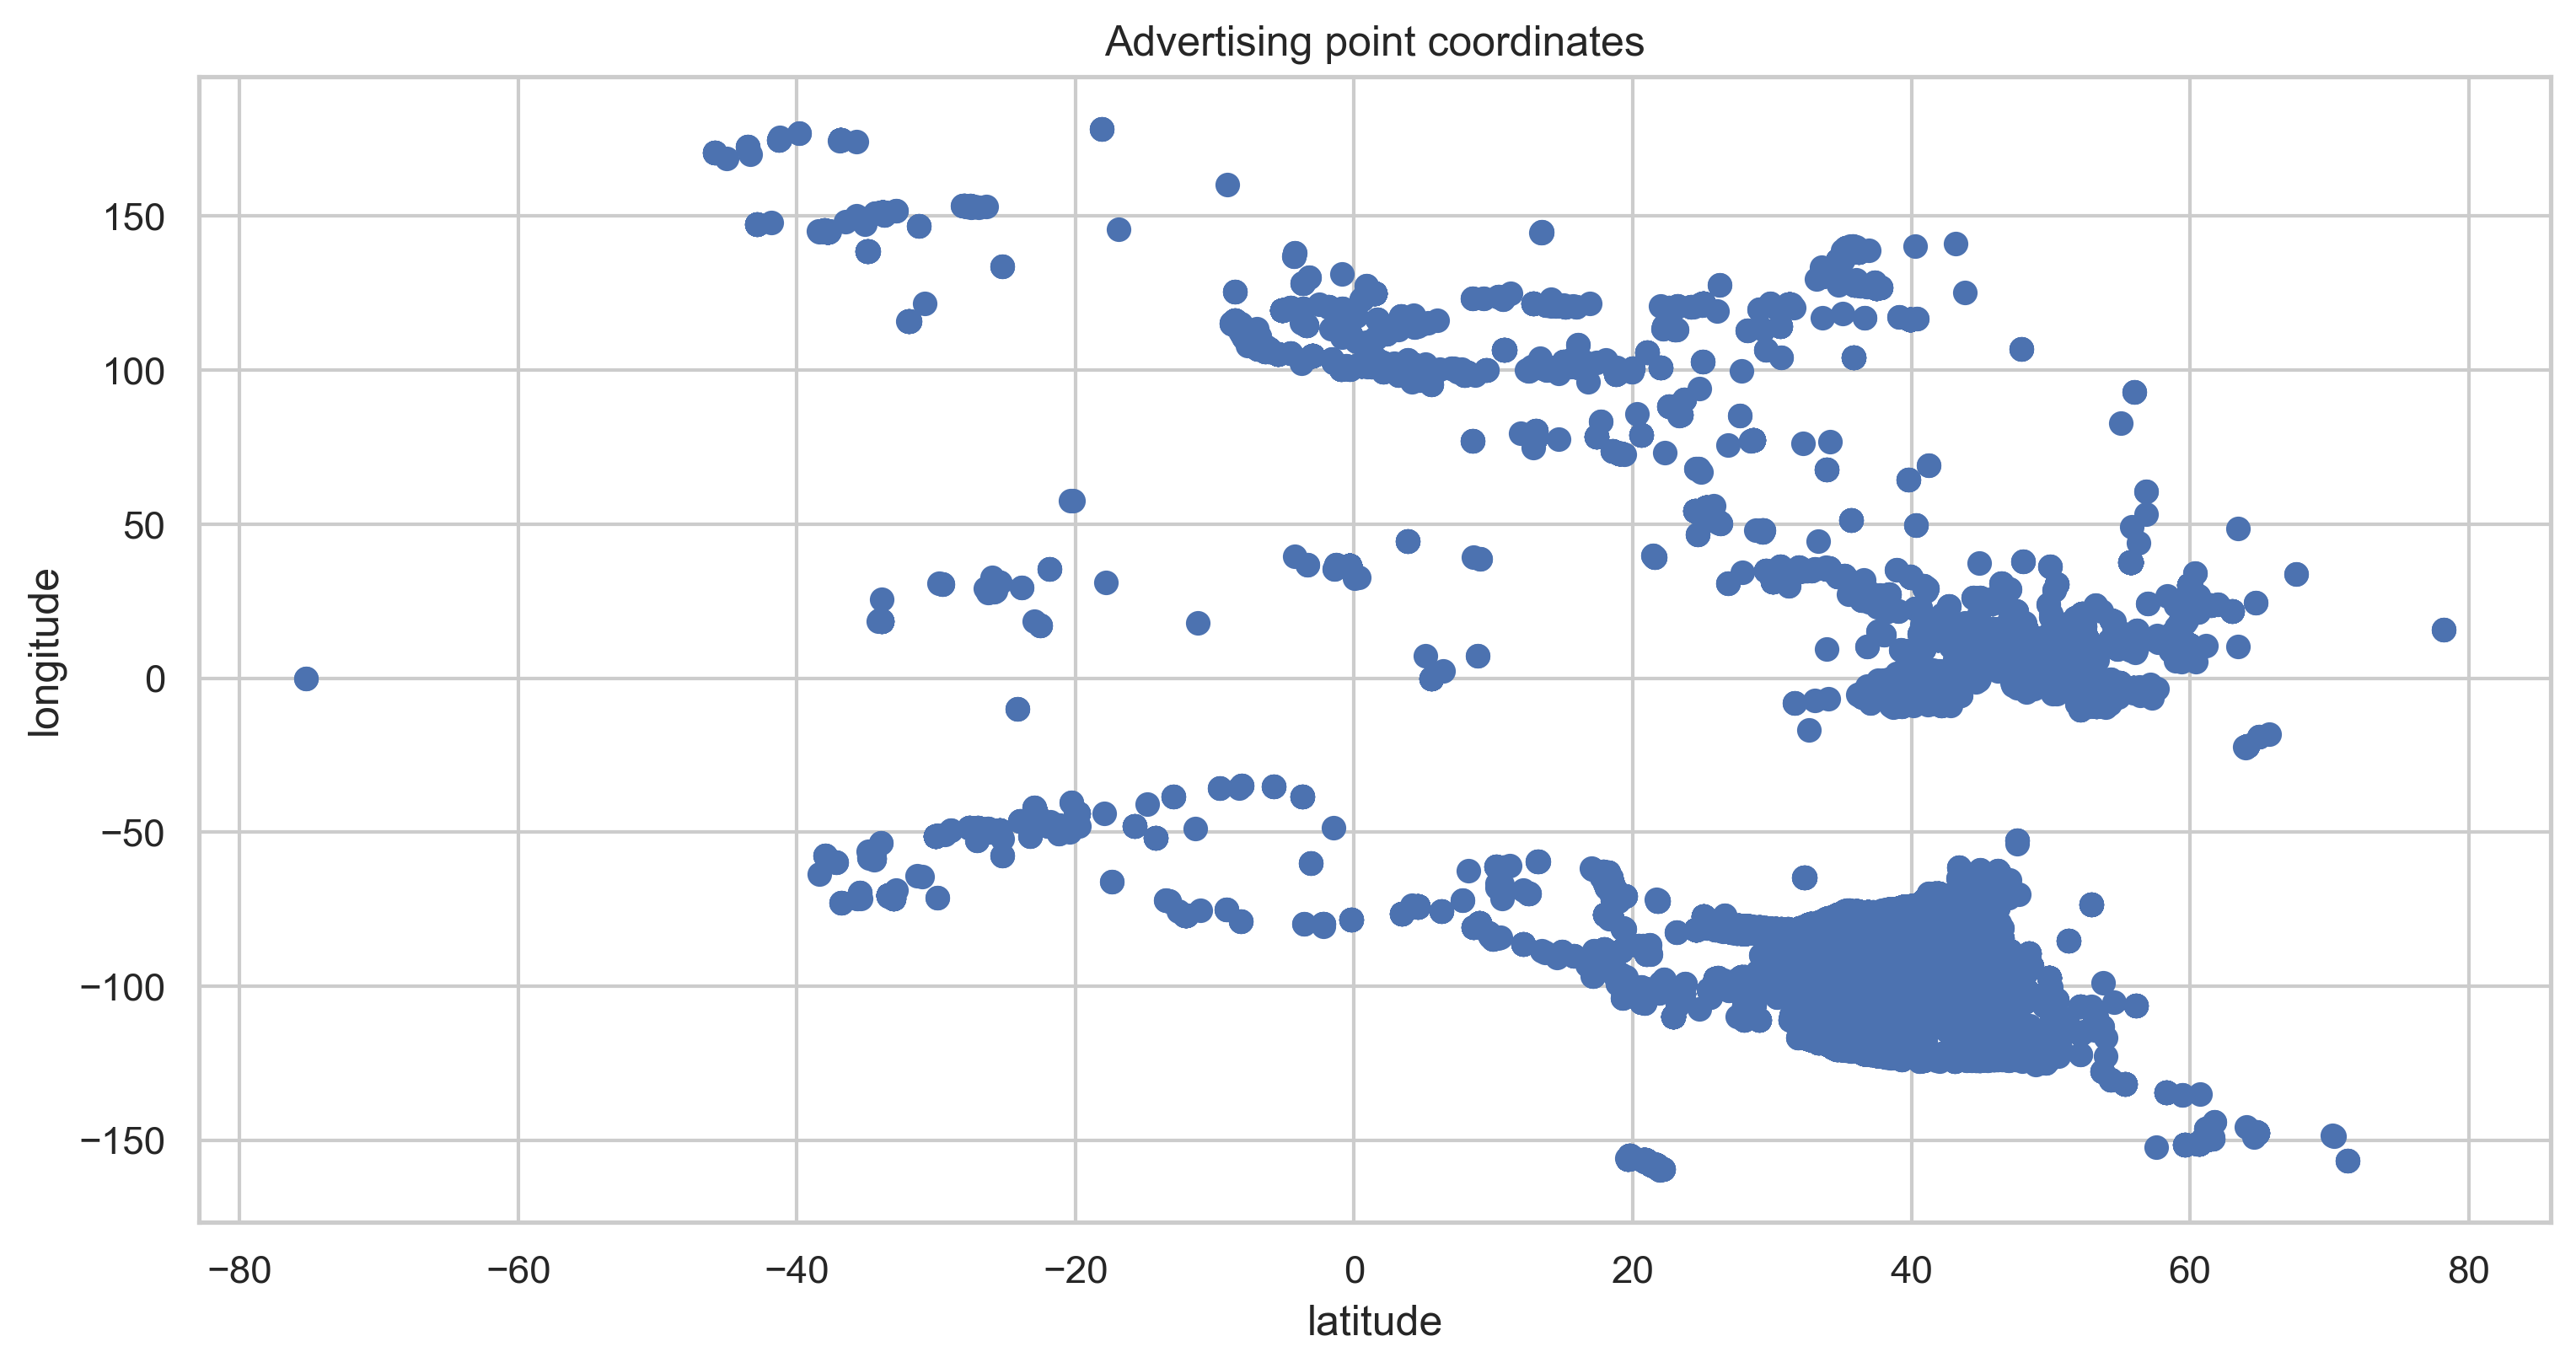

In [9]:
# df_subset = full_data.sample(n = 10000)

plt.scatter(full_data['latitude'], full_data['longitude'])
plt.title('Advertising point coordinates')
plt.xlabel('latitude')
plt.ylabel('longitude')

Working with dates

Observation period: (Timestamp('2011-12-08 04:17:50'), Timestamp('2012-04-23 01:53:50'))


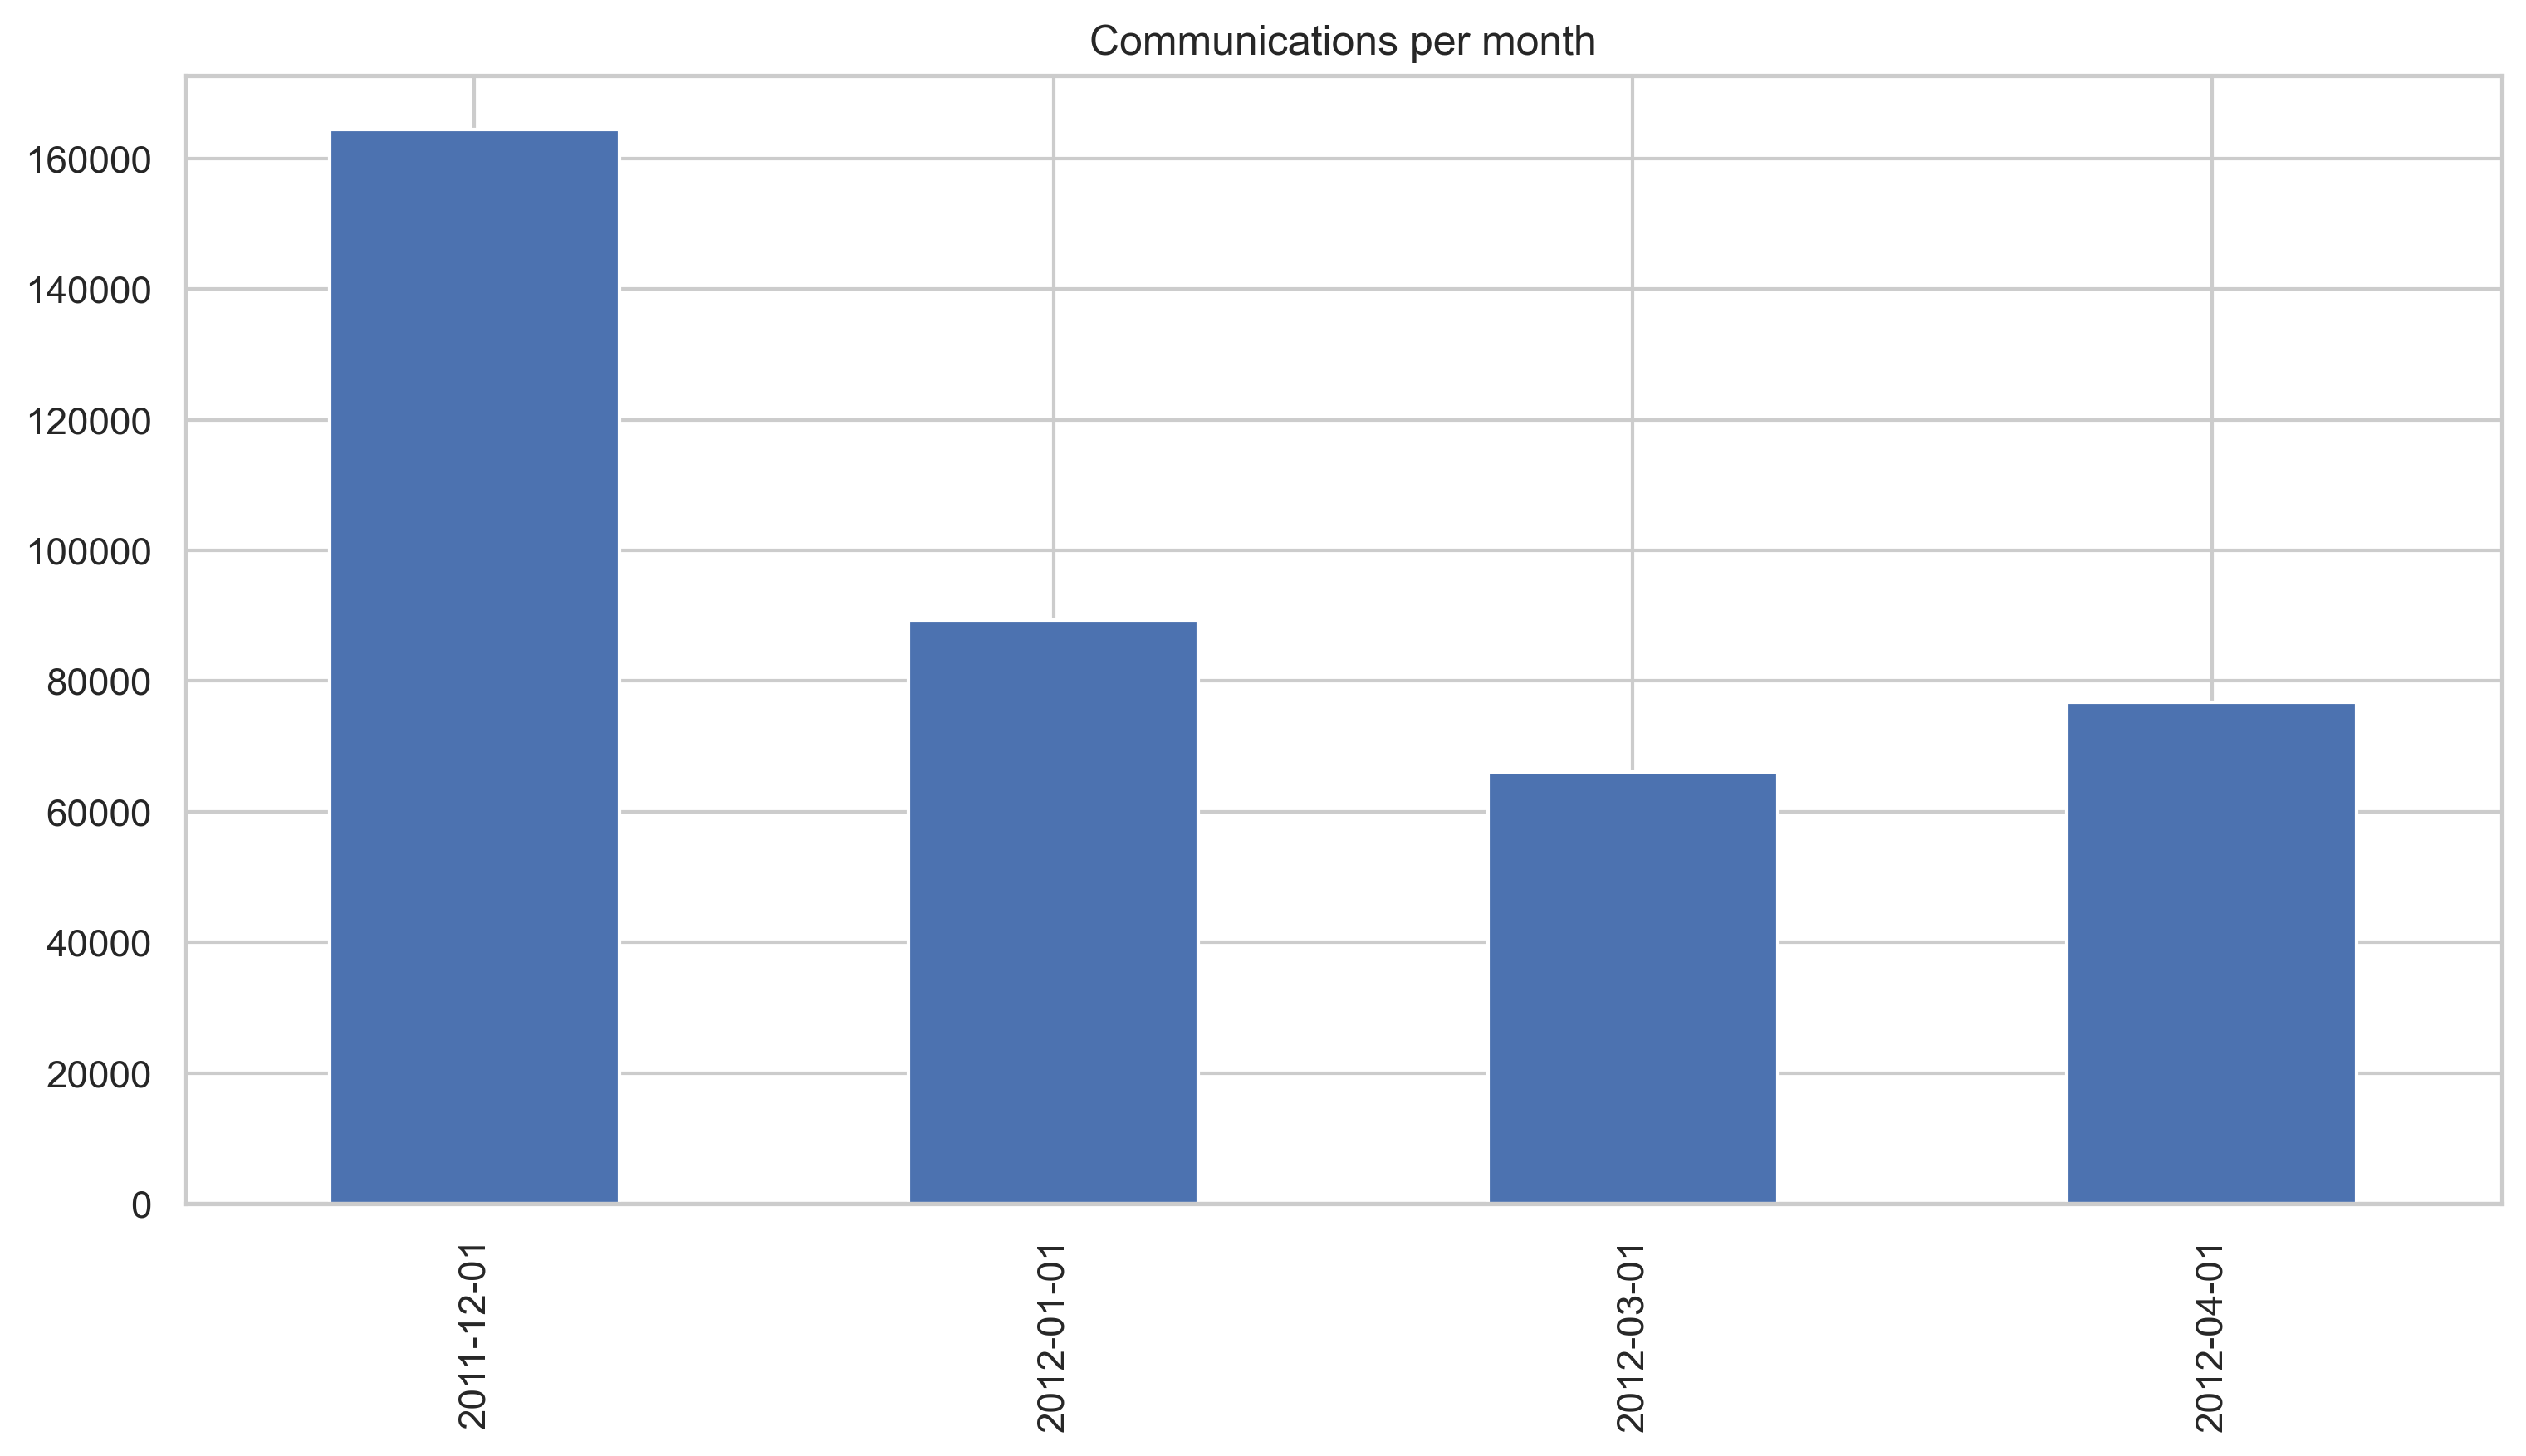

In [10]:
date_col= 'created_at'

full_data = date_preprocessing(full_data, date_col)

## Model - MeanShift

[link](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html#sklearn.cluster.MeanShift)

In [11]:
office_data = [[33.751277, -118.188740, 'Los Angeles'], 
               [25.867736, -80.324116, 'Miami'],
            [51.503016, -0.075479, 'London'],
            [52.378894, 4.885084, 'Amsterdam'],
            [39.366487, 117.036146, 'Beijing'],
            [-33.868457, 151.205134, 'Sydney']]

df_office = pd.DataFrame(office_data, columns=['latitude', 'longitude', 'city'])

In [12]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)
    #return cm.rainbow(np.linspace(0, 1, n))

    
def get_distance(lat1, lon1, lat2, lon2):
    return ((lat1 - lat2)**2 + (lon1 - lon2)**2) ** 0.5


def get_min_distance_to_office(lat, lon):
    min_dist = None
    for (of_lat, of_lon, city) in office_data:
        dist = get_distance(lat, lon, of_lat, of_lon)
        if (min_dist is None) or (dist < min_dist):
            min_dist = dist
    return min_dist

In [13]:
# living only subset of data to fuster traing
X = full_data[['id', 'latitude', 'longitude']][:100000].set_index('id') 

In [14]:
model = MeanShift(bandwidth=0.1).fit(X)
model.labels_

array([ 5,  7, 30, ..., 25, 19,  4], dtype=int64)

In [15]:
#Labels and cluster centers
labels = model.labels_
cluster_centers = model.cluster_centers_

print('Number of estimated clusters : %d' % len(cluster_centers))

#Count the number of items for each cluster
labels_unique, labels_counts = np.unique(labels, return_counts=True)

X['class'] = model.labels_

Number of estimated clusters : 3231


In [16]:
# live only classes with 15+ elements

major_classes = X['class'].value_counts()[X['class'].value_counts() > 15].index
df_final = X[X['class'].isin(major_classes)]

Text(0, 0.5, 'longitude')

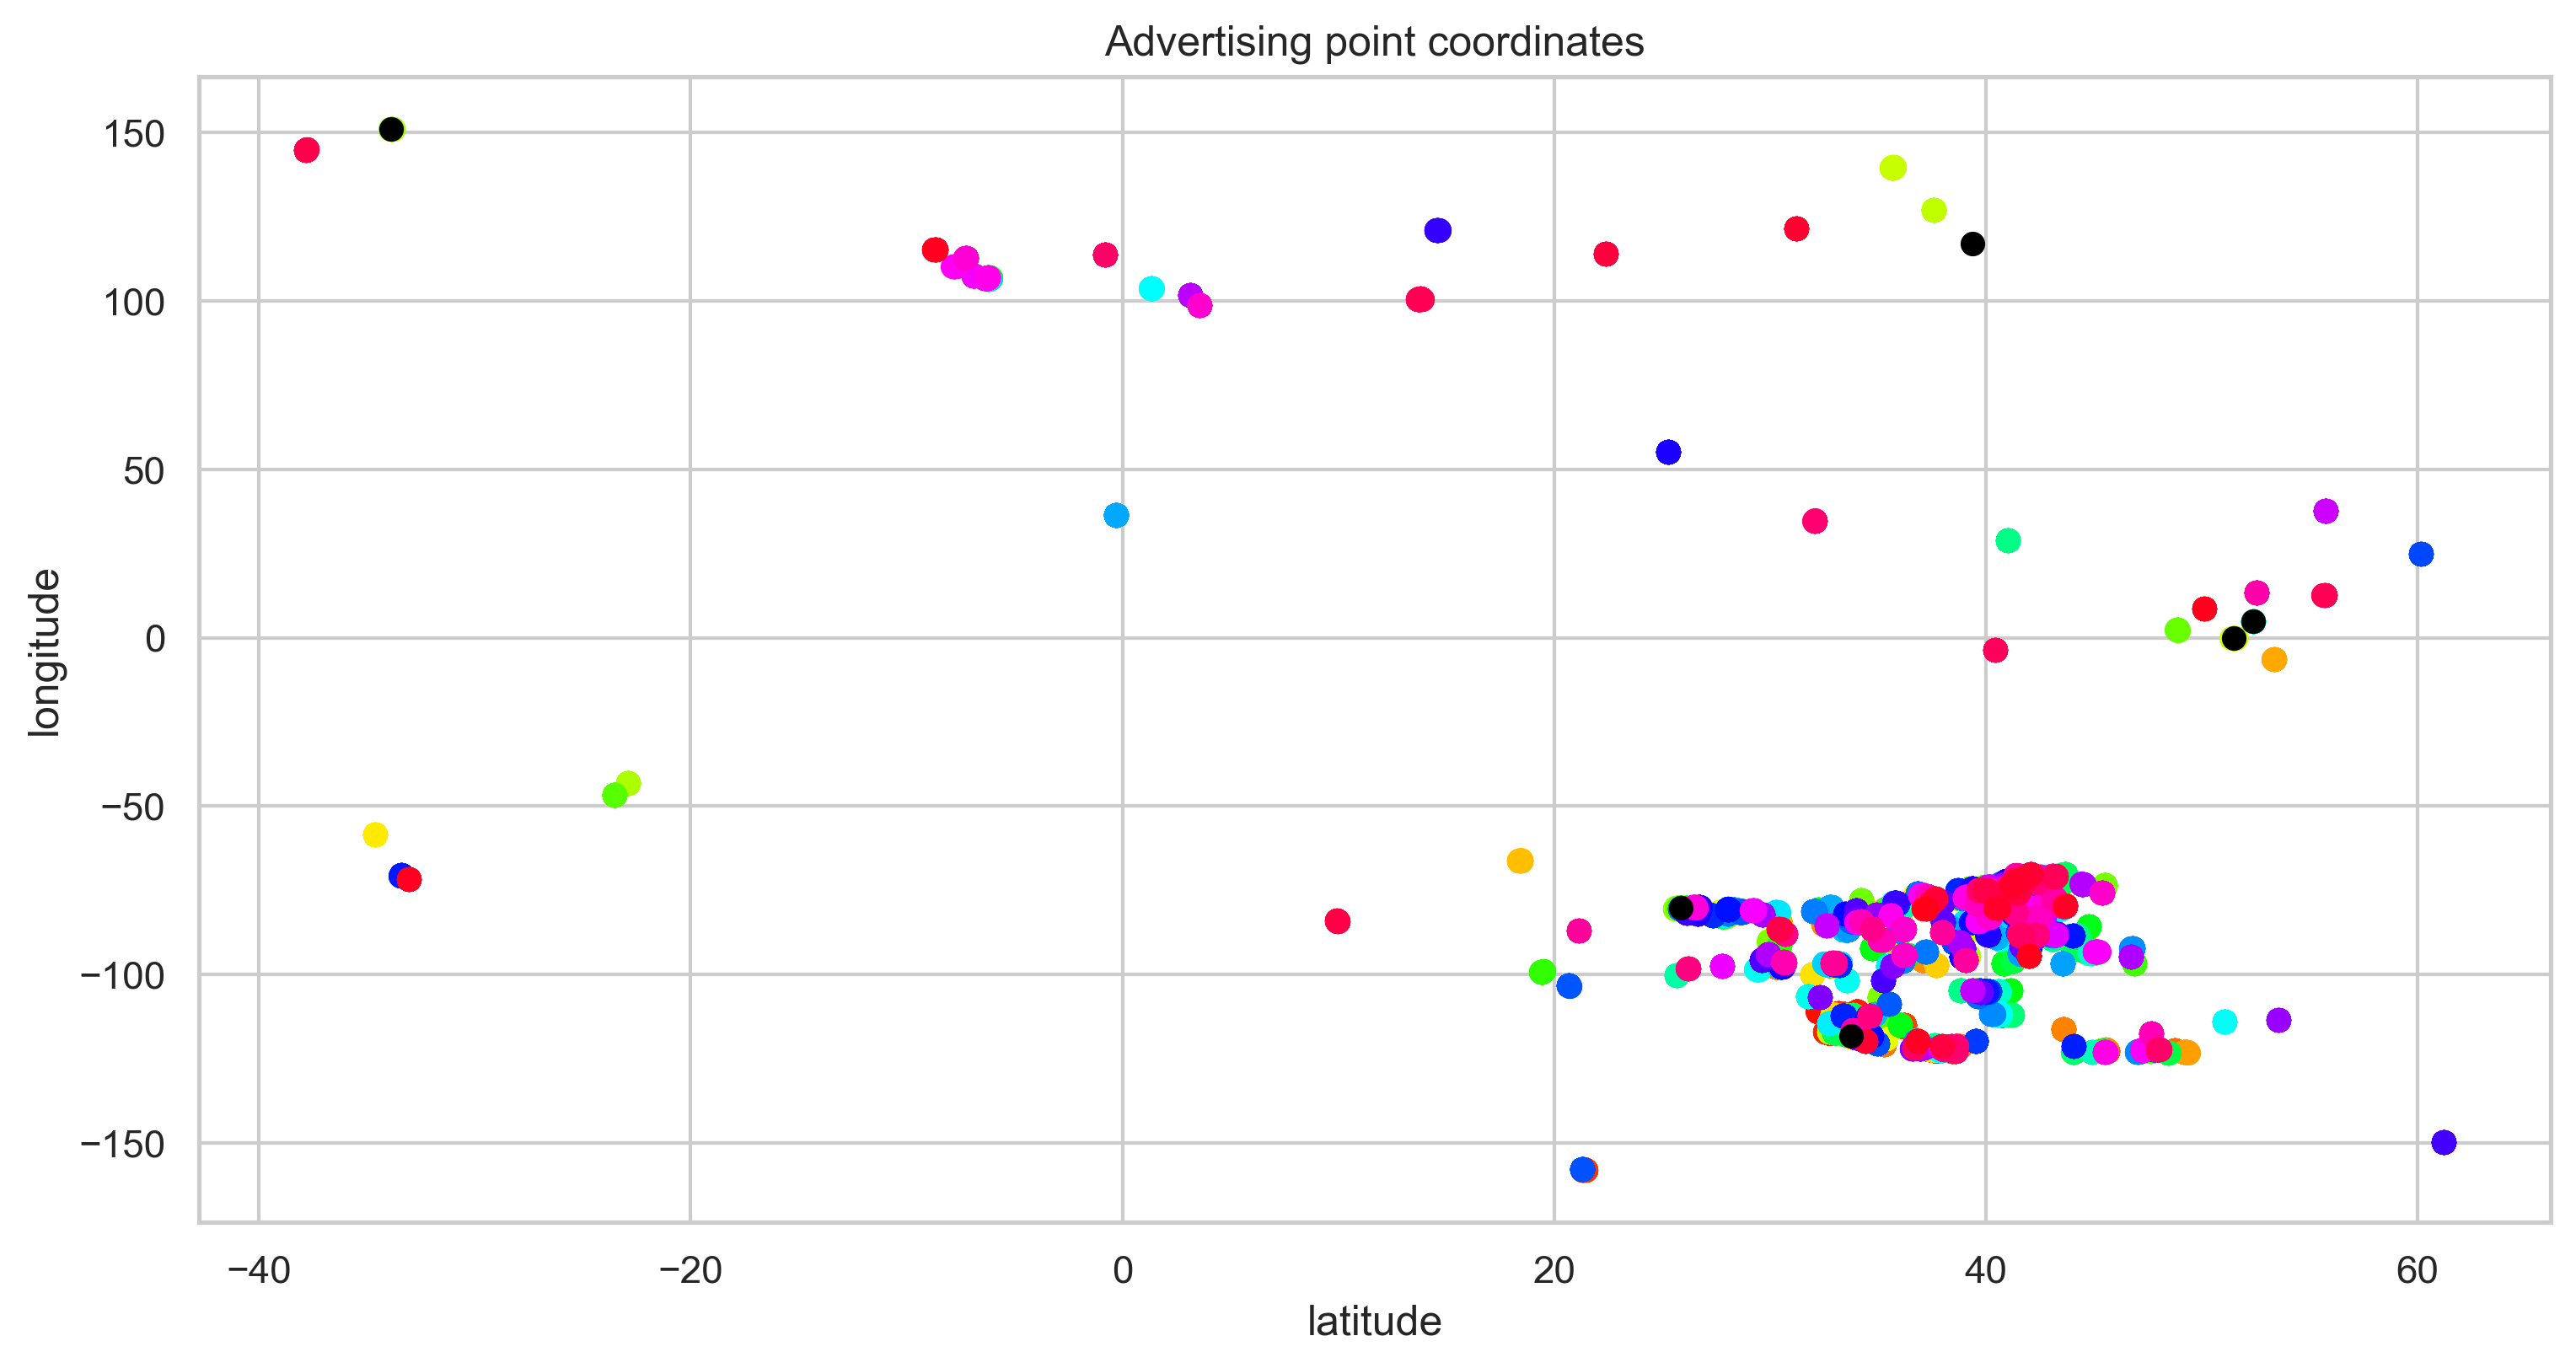

In [17]:
#

cmap = get_cmap( df_final['class'].nunique(), name='hsv')

#plt.legend(df_office['city'].unique())

for i, class_num in enumerate(df_final['class'].unique()):
    df_class = df_final[df_final['class'] == class_num]
    
    plt.scatter(x=df_class['latitude'], y=df_class['longitude'], color=cmap(i))
    
plt.scatter(x= df_office['latitude'], y=df_office['longitude'], color='black')#, color=colors[:,0])

#black_patch = mpatches.Circle((0.1, 0.1), color='black', label='City')
#plt.legend(handles=[black_patch])

plt.title('Advertising point coordinates')
plt.xlabel('latitude')
plt.ylabel('longitude')

## Closest cluster

In [18]:
# get center of clusters

cluster_centers = model.cluster_centers_
df_clusters = pd.DataFrame(cluster_centers, columns= ['cent_latitude', 'cent_longitude'])
df_clusters['size'] = X.groupby('class')['class'].count()

#df_cluster_centers = df_cluster_centers[df_cluster_centers.index.isin(major_classes)]
df_clusters = df_clusters[df_clusters['size'] > 15]

In [19]:
# get coordinates of cluster that closest to company office
df_clusters['distance'] = df_clusters.apply(lambda row: get_min_distance_to_office(row['cent_latitude'],row['cent_longitude']),axis=1)

df_clusters[df_clusters.distance == df_clusters.distance.min()]

,cent_latitude,cent_longitude,size,distance
420,-33.86063,151.204776,28,0.007835


---

## Another plot

In [20]:
labels = model.labels_
cluster_centers = model.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

number of estimated clusters : 3231


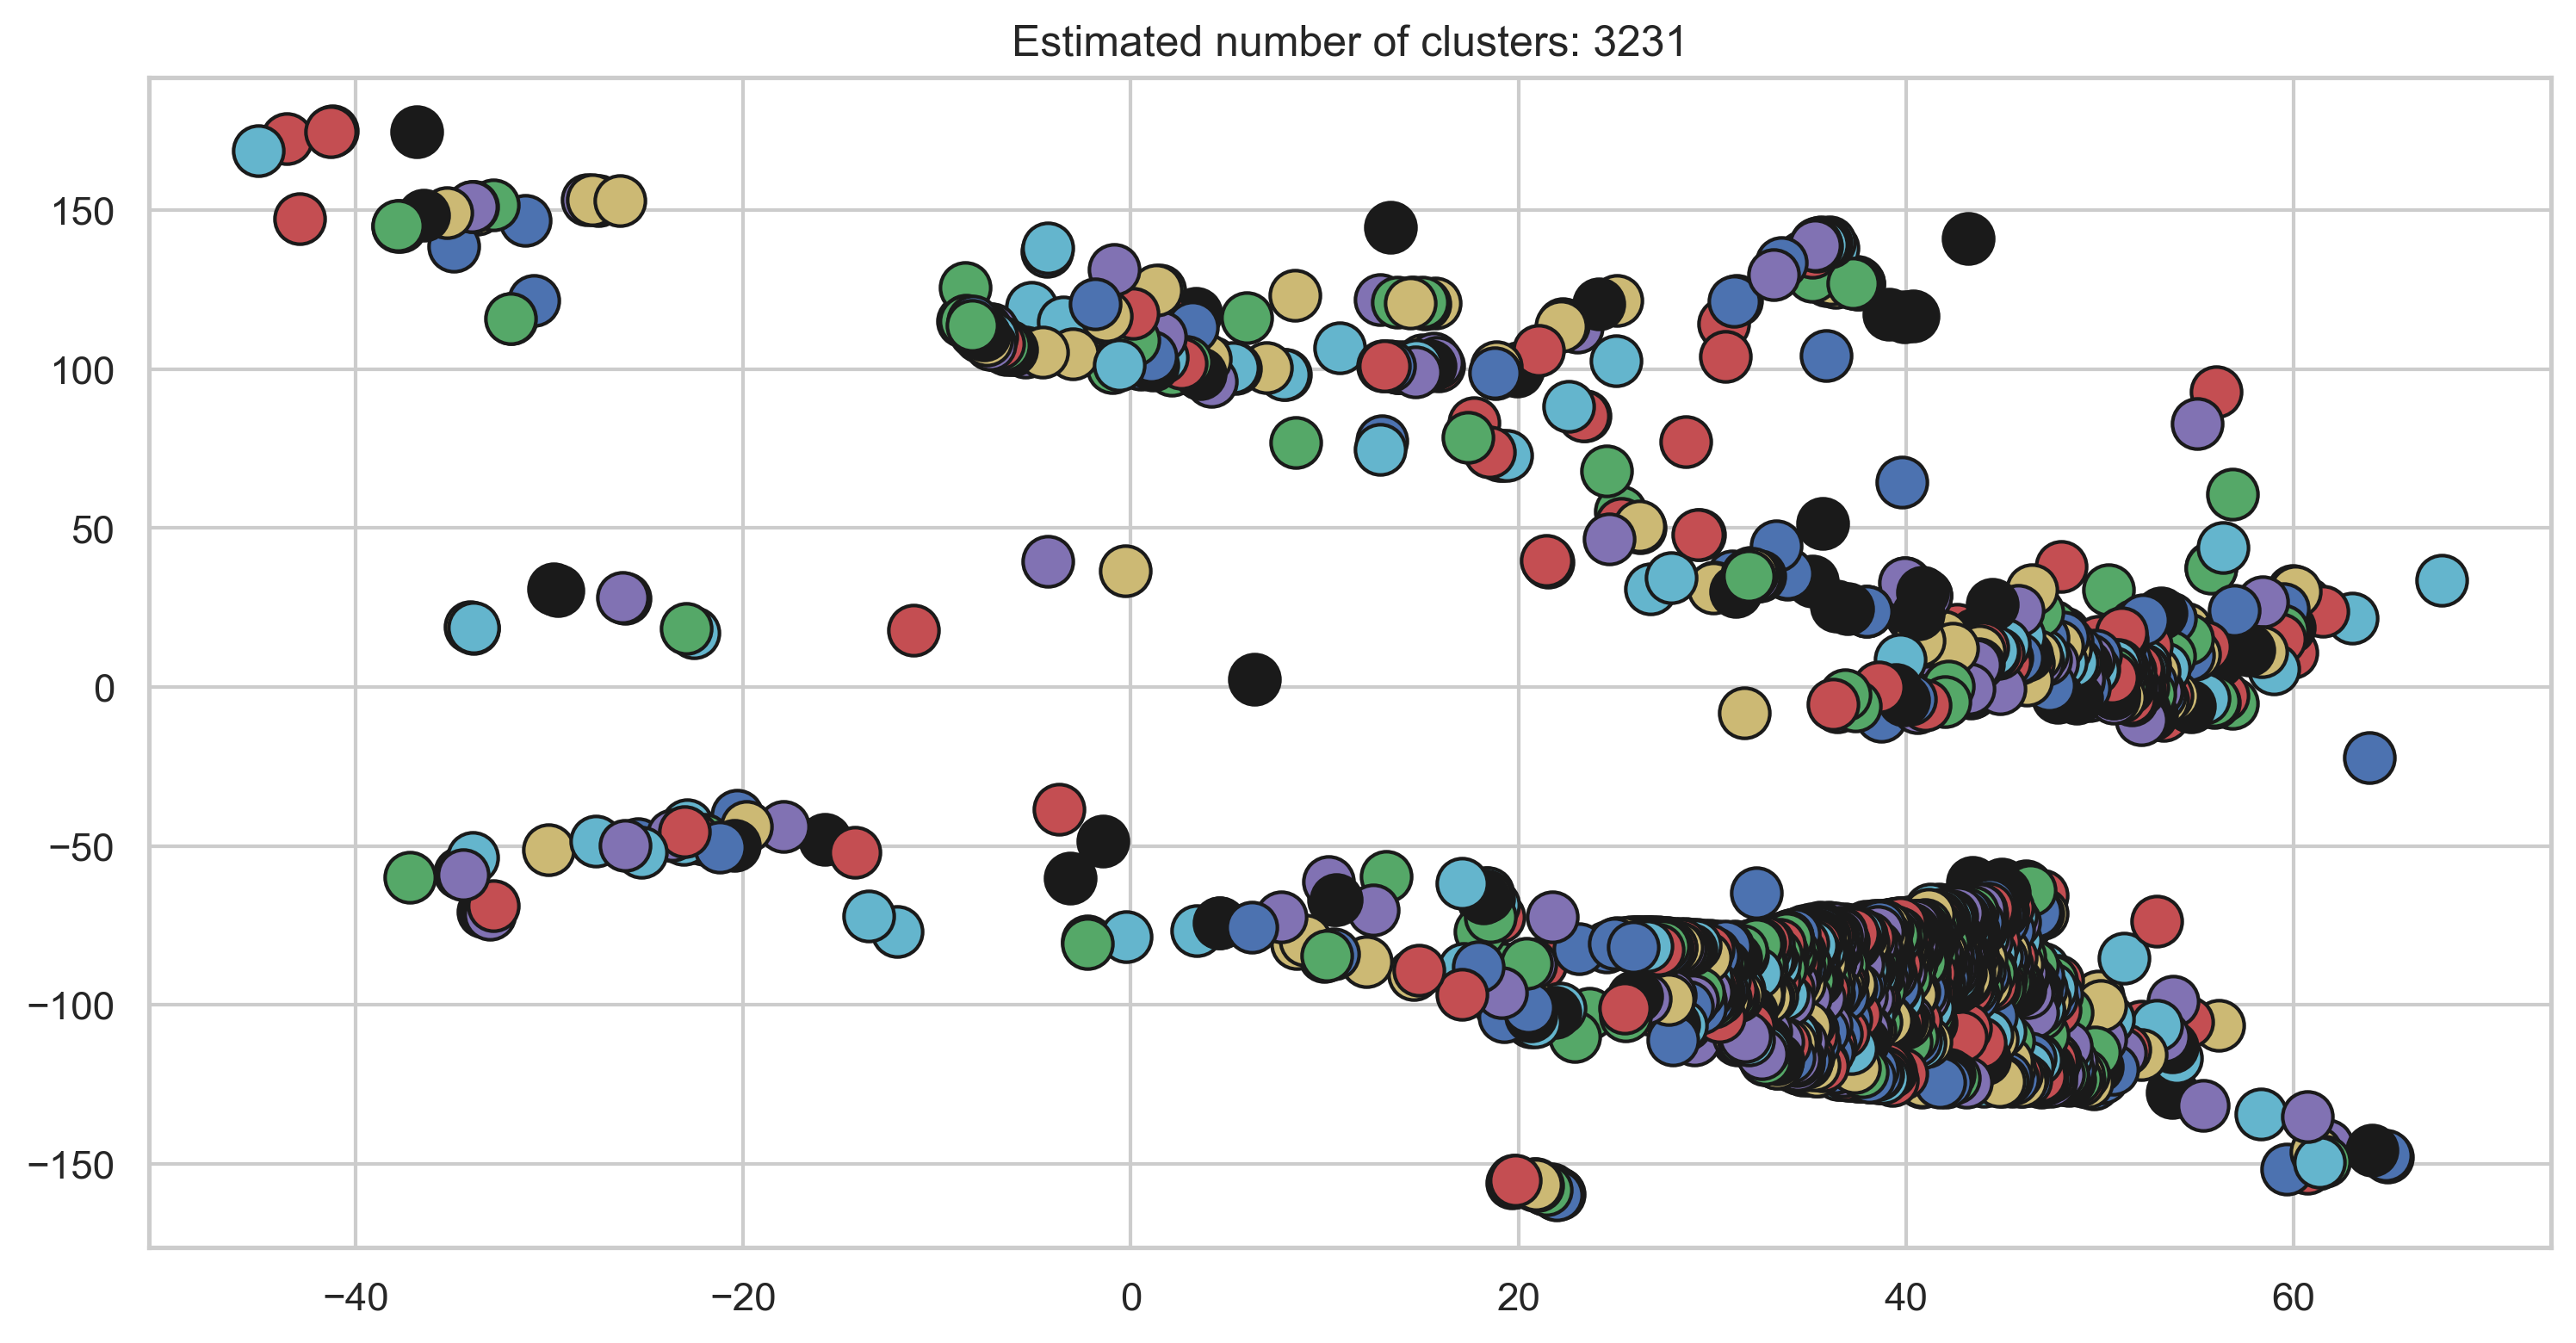

In [21]:
# #############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.figure(1)
plt.clf()

colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X.loc[my_members, 'latitude'], X.loc[my_members, 'longitude'], col + ".")
    plt.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=14,
    )
plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()